In [1]:
import os, sys, torch
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as tf
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm

sys.path.append("..")

from models.vis_utils import show_img_batch
%matplotlib inline

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.5,0.5,0.5]) # [0.485, 0.456, 0.406], [0.5,0.5,0.5]
std = np.array([0.5,0.5,0.5])  # [0.229, 0.224, 0.225], [0.5,0.5,0.5]

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std )])

class CelebAHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0


imagenet_dt = ImageFolder(root="../datasets/imagenet_subset", transform=transform)
imagenet_dl = DataLoader(imagenet_dt, batch_size=64, shuffle=True)
celebaHQ_dt = CelebAHQDataset(root_dir="../datasets/celeba_mask_hq/celeba_hq_img_downsampled", transform=transform)
celebaHQ_dl = DataLoader(celebaHQ_dt, batch_size=64, shuffle=True)


Max value 1.0, min value -1.0.


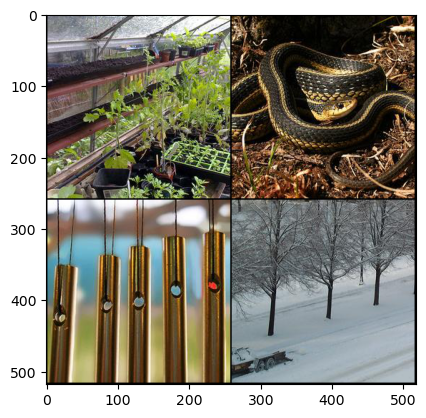

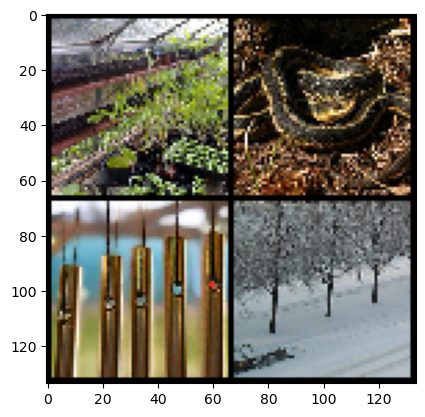

In [3]:
sample_dl = imagenet_dl # imagenet_dl, celebaHQ_dl
img_batch, labels = next(iter(sample_dl))
print(f"Max value {img_batch.max()}, min value {img_batch.min()}.")
img_inter = tf.interpolate(img_batch, size=img_batch.shape[-1]//4)
show_img_batch((img_batch+1)/2, n_images=4, nrow=2, size=img_batch.shape[1:])
show_img_batch((img_inter+1)/2, n_images=4, nrow=2, size=img_inter.shape[1:])

In [4]:
# # Check that all images have the same size in each dataset
# idx = 1
# for img_batch, labels in imagenet_dl:
#     if not (img_batch.shape[2:] == (256, 256)):
#         print(f"index {idx} image shape is {img_batch.shape[2:]}")
#     if idx % 100 == 0: print(f"Checked {idx*16} images")
#     idx += 1

# idx = 1
# for img_batch in celebaHQ_dl:
#     if not (img_batch.shape[2:] == (1024, 1024)):
#         print(f"index {i} image shape is {img_batch.shape[2:]}")
#     if idx % 100 == 0: print(f"Checked {idx*16} images")
#     idx += 1

In [5]:
from models.SRGAN.modules import GenConvBlock, ResConvBlock

In [ ]:
class Generator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        # Define the layers based on the provided notation
        self.gen_conv1 = GenConvBlock(im_chan, hidden_dim,  kernel_size=3, stride=1)  # k_9-n_64-s1
        self.res_conv1 = ResConvBlock(hidden_dim * 1, kernel_size=3, stride=1)  # ResConvBlock(64,3,1)
        self.res_conv2 = ResConvBlock(hidden_dim * 1, kernel_size=3, stride=1)  # ResConvBlock(64,3,1)
        self.res_conv3 = ResConvBlock(hidden_dim * 1, kernel_size=3, stride=1)  # ResConvBlock(64,3,1)
        self.res_conv4 = ResConvBlock(hidden_dim * 1, kernel_size=3, stride=1)  # ResConvBlock(64,3,1)
        self.gen_conv2 = GenConvBlock(hidden_dim * 1, hidden_dim * 1, kernel_size=3, stride=1, use_bn=True, use_prelu=False)   # k_3-n_64-s1
        self.gen_conv3 = GenConvBlock(hidden_dim * 1, hidden_dim * 4, kernel_size=3, stride=1, use_pxshuffle=True)   # k_3-n_256-s1
        self.gen_conv4 = GenConvBlock(hidden_dim * 1, hidden_dim * 4, kernel_size=3, stride=1, use_pxshuffle=True)   # k_3-n_256-s1
        self.gen_conv5 = GenConvBlock(hidden_dim * 1, im_chan, kernel_size=3, stride=1, use_prelu=True)       # k_9-n_3-s1


    def forward(self, x):
        # Define the forward pass
        x1 = self.gen_conv1(x)
        x2 = self.res_conv1(x1)
        x3 = self.res_conv2(x2)
        x4 = self.res_conv3(x3)
        x5 = self.res_conv4(x4)
        x6 = self.gen_conv2(x5)
        x7 = self.gen_conv3(x6+x1)
        x8 = self.gen_conv4(x7)
        out = self.gen_conv5(x8)
        return out

factor = 4
input_tensor = torch.randn(10, 3, 16*factor, 16*factor, device=device)  # Batch of 10 images, 3 channels, 512x512
x = input_tensor.to(device)
print(f"Input shape: {x.shape}")

generator = Generator(3, 64).to(device)
for layer in generator.children():
    x = layer(x)
    print(f"Output shape after {layer.__class__.__name__}: {x.shape}")


print(f"Output shape after generator: {generator(input_tensor).shape}")

In [7]:
class DiscConvBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, kernel_size=3, stride=1, use_bn=False):
        super(DiscConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.lrelu = nn.LeakyReLU(negative_slope=+.2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.use_bn = use_bn

    def forward(self, x):
        out = self.conv(x)
        if self.use_bn:
            out = self.bn(x)
        out = self.lrelu(out)
        return out 

In [ ]:
class ImagenetDiscriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(ImagenetDiscriminator, self).__init__()
        self.conv1 = DiscConvBlock(im_chan       , hidden_dim * 1, kernel_size=3, stride=2)
        self.conv2 = DiscConvBlock(hidden_dim * 1, hidden_dim * 1, kernel_size=3, stride=2)
        self.conv3 = DiscConvBlock(hidden_dim * 1, hidden_dim * 2, kernel_size=3, stride=2)
        self.conv4 = DiscConvBlock(hidden_dim * 2, hidden_dim * 2, kernel_size=3, stride=2)
        self.conv5 = DiscConvBlock(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=2)
        self.conv6 = DiscConvBlock(hidden_dim * 4, hidden_dim * 4, kernel_size=3, stride=2)
        self.conv7 = DiscConvBlock(hidden_dim * 4, hidden_dim * 8, kernel_size=3, stride=2)
        self.conv8 = DiscConvBlock(hidden_dim * 8, hidden_dim * 4, kernel_size=3, stride=2)
        self.conv9 = DiscConvBlock(hidden_dim * 4, 1, kernel_size=3, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        return x.view(-1, 1)
    

# Example usage
input_tensor = torch.randn(10, 3, 256, 256, device=device)  # Batch of 10 images, 3 channels, 512x512
discriminator = ImagenetDiscriminator(3, 64).to(device)

# Pass the input through each layer and print the output shape
x = input_tensor
print(f"Input shape to ImagenetDiscriminator: {x.shape}")

for layer in discriminator.children():
    x = layer(x)
    print(f"Output shape after {layer.__class__.__name__}: {x.shape}")


print(f"Output shape after ImagenetDiscriminator: {discriminator(input_tensor).shape}")
print(f"-----------------------------------------------------------------------------")

class CelebaHQDiscriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(CelebaHQDiscriminator, self).__init__()
        self.conv1  = DiscConvBlock(im_chan       , hidden_dim * 1, kernel_size=3, stride=2)
        self.conv2  = DiscConvBlock(hidden_dim * 1, hidden_dim * 1, kernel_size=3, stride=2)
        self.conv3  = DiscConvBlock(hidden_dim * 1, hidden_dim * 2, kernel_size=3, stride=2)
        self.conv4  = DiscConvBlock(hidden_dim * 2, hidden_dim * 2, kernel_size=3, stride=2)
        self.conv5  = DiscConvBlock(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=2)
        self.conv6  = DiscConvBlock(hidden_dim * 4, hidden_dim * 4, kernel_size=3, stride=2)
        self.conv7  = DiscConvBlock(hidden_dim * 4, hidden_dim * 8, kernel_size=3, stride=2)
        self.conv8  = DiscConvBlock(hidden_dim * 8, hidden_dim * 8, kernel_size=3, stride=2)
        self.conv9  = DiscConvBlock(hidden_dim * 8, hidden_dim * 2, kernel_size=3, stride=2)
        self.conv10 = DiscConvBlock(hidden_dim * 2, 1, kernel_size=3, stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        return x.view(-1, 1)
    

# Example usage
input_tensor = torch.randn(10, 3, 512, 512, device=device)  # Batch of 10 images, 3 channels, 512x512
discriminator = CelebaHQDiscriminator(3, 128).to(device)

# Pass the input through each layer and print the output shape
x = input_tensor
print(f"Input shape to CelebaHQDiscriminator: {x.shape}")

for layer in discriminator.children():
    x = layer(x)
    print(f"Output shape after {layer.__class__.__name__}: {x.shape}")


print(f"Output shape after CelebaHQDiscriminator: {discriminator(input_tensor).shape}")

In [21]:
from torchvision.models import vgg19
from torch import nn
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Load the pretrained VGG19 model
        vgg19_model = vgg19(pretrained=True)
        # Use the features part of the model
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])
    def forward(self, x):
        # Extract features from the input

        return self.feature_extractor(x)
    
feature_extractor = FeatureExtractor().to(device)
feature_extractor(tf.interpolate(img_batch.to(device), size=256)).shape

/opt/anaconda3/envs/torchpy310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torchpy310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 256, 64, 64])

## Training

In [10]:
bce = nn.BCEWithLogitsLoss() 
l1loss = nn.L1Loss() 
lambda_rec = 1000
lambda_feat = 1000

n_epochs = 25
display_step = 1500
batch_size = 64
factor_hr = 1
factor_lr = 4

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

device = "mps" if torch.backends.mps.is_available() else "cpu"

im_chan = 3
hidden_dim = 64

In [ ]:
imagenet_dt = ImageFolder(root="../datasets/imagenet_subset", transform=transform)
imagenet_dl = DataLoader(imagenet_dt, batch_size=batch_size, shuffle=True)
celebaHQ_dt = CelebAHQDataset(root_dir="../datasets/celeba_mask_hq/celeba_hq_img_downsampled", transform=transform)
celebaHQ_dl = DataLoader(celebaHQ_dt, batch_size=batch_size, shuffle=True)

# sample images
imagenet_batch, _ = next(iter(imagenet_dl))
print(f"Imagenet image shape: {imagenet_batch.shape}")
celebaHQ_batch, _ = next(iter(celebaHQ_dl))
print(f"celebaHQ image shape: {celebaHQ_batch.shape}")

In [ ]:
# Initialize the generator and discriminator
gen = Generator(im_chan=im_chan, hidden_dim=64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),   lr=lr, betas=(beta_1, beta_2))
disc = ImagenetDiscriminator(im_chan=im_chan, hidden_dim=hidden_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# Initialize the feature extractor
feature_extractor = FeatureExtractor().to(device)
feature_extractor(tf.interpolate(img_batch.to(device), size=256)).shape

In [ ]:
for img_batch, _ in tqdm(celebaHQ_dl):
        
    img_batch_hr = tf.interpolate(img_batch, size=img_batch.shape[-1]//factor_hr)
    img_batch_lr = tf.interpolate(img_batch, size=img_batch.shape[-1]//factor_lr)
    
    real_hr = img_batch_hr.to(device)
    real_lr = img_batch_lr.to(device)
    print(f"Real HR {real_hr.shape}, real LR {real_lr.shape}, fake HR {gen(real_lr).shape}")
    break

for img_batch, _ in tqdm(imagenet_dl):
        
    img_batch_hr = tf.interpolate(img_batch, size=img_batch.shape[-1]//1)
    img_batch_lr = tf.interpolate(img_batch, size=img_batch.shape[-1]//4)
    
    real_hr = img_batch_hr.to(device)
    real_lr = img_batch_lr.to(device)
    print(f"Real HR {real_hr.shape}, real LR {real_lr.shape}, fake HR {gen(real_lr).shape}")
    break

In [ ]:
cur_step = 1
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for img_batch, _ in tqdm(imagenet_dl):
        
        target_hr = img_batch.shape[-1]//factor_hr
        target_lr = img_batch.shape[-1]//factor_lr 
        img_batch_hr = tf.interpolate(img_batch, size=target_hr)
        img_batch_lr = tf.interpolate(img_batch, size=target_lr)
        
        real_hr = img_batch_hr.to(device)
        real_lr = img_batch_lr.to(device)
        
        # Train discriminator
        disc_opt.zero_grad()
        with torch.no_grad():
            fake_hr = gen(real_lr)
        disc_fake_hr = disc(fake_hr.detach())
        disc_fake_loss = bce(disc_fake_hr, torch.zeros_like(disc_fake_hr, device=device)) 

        disc_real_hr = disc(real_hr)
        disc_real_loss = bce(disc_real_hr, torch.ones_like(disc_real_hr, device=device))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses.append(disc_loss.item())

        # Train generator
        gen_opt.zero_grad()
        fake_hr = gen(real_lr)
        gen_fake_hr = disc(fake_hr)
        gen_loss = bce(gen_fake_hr, torch.ones_like(gen_fake_hr, device=device)) 
        
        # # Reconstruction loss
        loss_recon = l1loss(fake_hr, real_hr)

        # Content loss
        gen_features  = feature_extractor(fake_hr)
        real_features = feature_extractor(real_hr)
        loss_features  = l1loss(gen_features, real_features.detach())
        
        gen_loss += lambda_feat*loss_features # + lambda_rec*loss_recon
        gen_loss.backward()
        gen_opt.step()

        generator_losses.append(gen_loss.item())

        if cur_step % display_step == 0:
            mean_gen_loss  = sum(generator_losses[-display_step:]) / display_step
            mean_disc_loss = sum(discriminator_losses[-display_step:]) / display_step
            if cur_step > 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_disc_loss}")
            else:
                print("Pretrained initial state")
            show_img_batch((real_hr+1)/2, n_images=4, size=(3, target_hr, target_hr))
            show_img_batch((real_lr+1)/2, n_images=4, size=(3, target_lr, target_lr))
            show_img_batch((fake_hr+1)/2, n_images=4, size=(3, target_hr, target_hr))
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


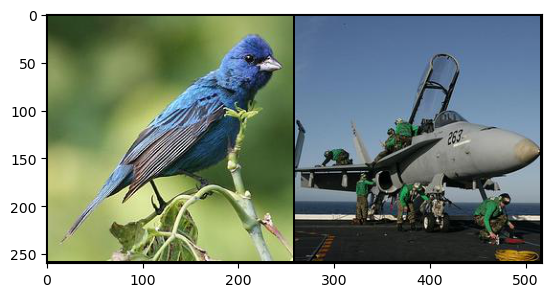

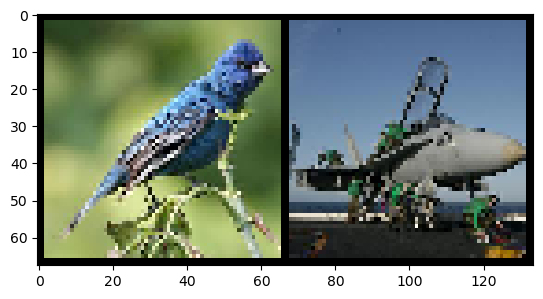

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10391575..0.98649204].


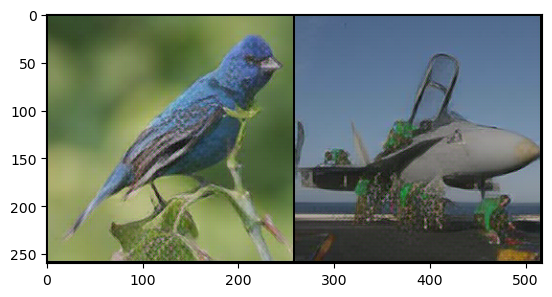

In [17]:
show_img_batch((real_hr+1)/2, n_images=2, size=(3, target_hr, target_hr))
show_img_batch((real_lr+1)/2, n_images=2, size=(3, target_lr, target_lr))
show_img_batch((fake_hr+1)/2, n_images=2, size=(3, target_hr, target_hr))

In [63]:
from datetime import datetime as dt
dt_str = dt.now().strftime("%y%m%d_%H%M%S")
torch.save({
    'gen_state': gen.state_dict(), 
    'gen_opt_state': gen_opt.state_dict(),
    'crit_state': disc.state_dict(),
    'crit_opt_state': disc_opt.state_dict(),
    'epoch': epoch,
    "generator_losses": generator_losses,
    "discriminator_losses": discriminator_losses,
    }, 
    f'biggan_{dt_str}.pth'
)